In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import colorsys
import os
import imageio
import re
import itertools
import pandas as pd
import csv

In [2]:
def network_evolution(state, t, W, alpha, omega, coupled_neuron, inputn):
    """
    Computes the derivatives of system parameters (densities and phases)
    
    :param state: np.array, vector of densities and phases (rho_1, rho_2, ..., rho_n, theta_1, ..., theta_n)
    :param t: float, current time
    :param W: np.array coupling matrix
    :param alpha: float, constant parameter
    :param omega: np.array, vector of frequencies
    :return: np.array, derivatives of state (state like)
    """
    N = int(len(state)/2)
    dstate_dt = np.zeros_like(state)
    coupled_values_den = state[coupled_neuron]
    coupled_values_phase = state[N+coupled_neuron]
    for neuron in range(N):
        if neuron in inputn:
            #dden_dt = -alpha*state[neuron]*state[neuron]*state[neuron]
            #dden_dt += np.sum(W[neuron]*coupled_values_den*np.cos(coupled_values_phase-state[N+neuron]))
            dden_dt=0
            dstate_dt[neuron] = dden_dt
            dstate_dt[N+neuron] = 0
        else:
            dden_dt = -alpha*state[neuron]*state[neuron]*state[neuron]
            dden_dt += np.sum(W[neuron]*coupled_values_den*np.cos(coupled_values_phase-state[N+neuron]))

            dphase_dt = omega[neuron] + np.sum(W[neuron]*coupled_values_den/state[neuron]*np.sin(coupled_values_phase-state[N+neuron]))

            dstate_dt[neuron] = dden_dt
            dstate_dt[N+neuron] = dphase_dt
    return dstate_dt

def network_evolution_nudge(state, t, W, alpha, omega, coupled_neuron, inputn, beta_den, beta_phase, target):
    """
    Computes the derivatives of system parameters (densities and phases) after nudge of dynamics
    
    :param state: np.array, vector of densities and phases (rho_1, rho_2, ..., rho_n, theta_1, ..., theta_n)
    :param t: float, current time
    :param W: np.array coupling matrix
    :param alpha: float, constant parameter
    :param omega: np.array, vector of frequencies
    :param beta_den: np.array, density nudge strength (zeros differentiate from output)
    :param beta_phase: np.array, phase nudge strength (zeros differentiate from output)
    :param target: np.array, target state
    :return: np.array, derivatives of state (state like)
    """
    N = int(len(state)/2)
    dstate_dt = np.zeros_like(state)
    coupled_values_den = state[coupled_neuron]
    coupled_values_phase = state[N+coupled_neuron]
    for neuron in range(N):
        if neuron in inputn:
            dden_dt = -alpha*state[neuron]*state[neuron]*state[neuron]
            dden_dt += np.sum(W[neuron]*coupled_values_den*np.cos(coupled_values_phase-state[N+neuron]))
            dstate_dt[neuron] = 0
            dstate_dt[N+neuron] = 0
        else:
            dden_dt = -alpha*state[neuron]*state[neuron]*state[neuron]
            dden_dt += np.sum(W[neuron]*coupled_values_den*np.cos(coupled_values_phase-state[N+neuron]))
            dden_dt += - beta_den[neuron]*(state[neuron]-target[neuron])

            dphase_dt = omega[neuron] + np.sum(W[neuron]*coupled_values_den/state[neuron]*np.sin(coupled_values_phase-state[N+neuron]))
            dphase_dt += - beta_phase[neuron]*np.sin(state[N+neuron]-target[N+neuron])/(np.cos(state[N+neuron]-target[N+neuron])+1+1e-8)

            dstate_dt[neuron] = dden_dt
            dstate_dt[N+neuron] = dphase_dt 
    return dstate_dt

In [24]:
N = 10 # number of neurons
neurons = np.arange(0,N,1) #
outputn = 2 #output neuron
inputn = [0,1] # input neurons
connections_neuronwise = np.array([[element for element in neurons if element != neuron] for neuron in neurons]) # connections between neurons

colors = ['green'] * N  # Default to green for all indices
colors[inputn[0]] = 'red'
colors[inputn[1]] = 'red'
colors[outputn] = 'blue'

weights_matrix = np.zeros((N,N)) # defining weights and initializing for lookup
for i in range(1,N):
    for j in range(0,i):
        weights_matrix[i][j] = np.random.normal(loc=0, scale=1)
        weights_matrix[j][i] = weights_matrix[i][j]
weights = weights_matrix[connections_neuronwise, np.arange(N)[:, None]] # defining weights for direct use
alpha = 1. # defining alpha parameter
omega = np.zeros(N) # defining frequencies (for now 0's)

In [25]:
densities = np.array([np.random.uniform(2.8, 3.2) for _ in neurons])
phases = np.array([np.random.uniform(-np.pi, np.pi) for _ in neurons])

densities[inputn[0]] = 5
densities[inputn[1]] = 4

state = np.concatenate((densities, phases))

T = 10
dt = 0.02
times = np.arange(0, T+dt, dt)

omega = np.zeros(N)
revolt = odeint(network_evolution, state, times, args=(weights, alpha, omega, connections_neuronwise, inputn), full_output=0)

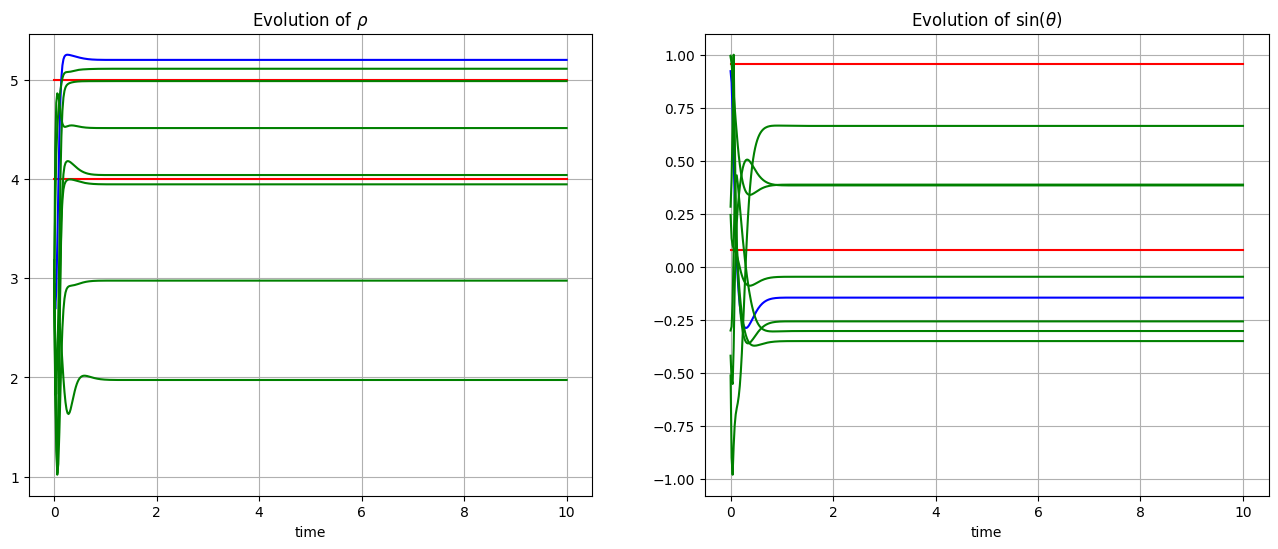

In [26]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 6)) 

for j in range(N):
    axes[0].plot(times, revolt[:,j], color=colors[j])
axes[0].set_title(r"Evolution of $\rho$")
axes[0].set_xlabel("time")
axes[0].grid()

for j in range(N):
    axes[1].plot(times, np.sin(revolt[:,N+j]), color=colors[j])
axes[1].set_xlabel("time")
axes[1].grid()
axes[1].set_title(r"Evolution of $\sin(\theta)$")
plt.show()

In [20]:
print(weights_matrix)

[[ 0.         -1.37233871 -0.86867701 -0.57297255  0.75850349  0.5688584 ]
 [-1.37233871  0.         -1.04347796 -1.17741695  0.81406843  0.79220239]
 [-0.86867701 -1.04347796  0.         -0.5138478  -0.97982347  0.19838823]
 [-0.57297255 -1.17741695 -0.5138478   0.         -0.13349879  1.21080042]
 [ 0.75850349  0.81406843 -0.97982347 -0.13349879  0.          1.03224239]
 [ 0.5688584   0.79220239  0.19838823  1.21080042  1.03224239  0.        ]]
